# nn.Linearのbiasについて

[機械学習帳8](https://chokkan.github.io/mlnote/regression/03regularization.html)の単層NNの学習例で``bias``について見てみる。

In [161]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib

In [162]:
def init_graph(X, dpi=100, figsize=(6,6)):
    xmin, xmax = X[:,0].min()-0.5, X[:,0].max()+0.5
    ymin, ymax = X[:,1].min()-0.5, X[:,1].max()+0.5

    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return fig, ax

def plot_data(ax, X, Y):
    I = np.where(Y == 0)
    ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')
    I = np.where(Y == 1)
    ax.scatter(X[I,0], X[I,1], c='tab:red', marker='+')
    
def draw_heatmap(fig, ax, func, step=1, N=1024):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    X_ = torch.from_numpy(XY).type(dtype)
    Y_ = func(X_).detach().numpy().copy()
    C = Y_.reshape(XX.shape)

    vmin, vmax = C.min(), C.max()
    vmin = ((vmin // step) - 1) * step
    vmax = ((vmax // step) + 1) * step
    width = max(abs(vmin), abs(vmax))
    
    mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Output value')
    
    cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
    cont.clabel(fmt='%1.1f')

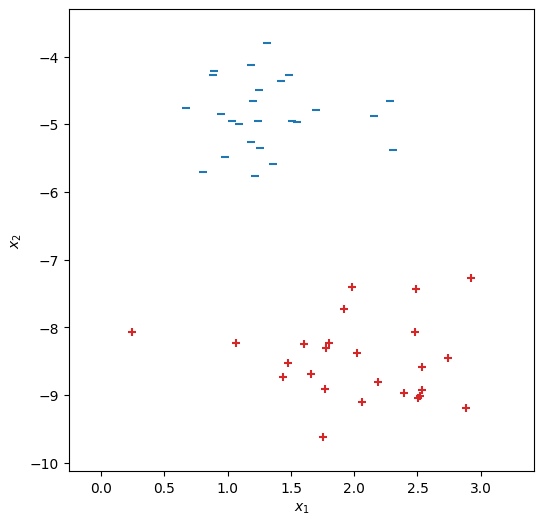

In [163]:
from sklearn.datasets import make_blobs
D = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)

fig, ax = init_graph(D[0])
plot_data(ax, D[0], D[1])
plt.show()

In [164]:
from torch.utils.data import TensorDataset, DataLoader

dtype = torch.float
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

In [165]:
X.shape

torch.Size([50, 2])

In [166]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=False)

loss_fn = torch.nn.BCEWithLogitsLoss()

In [167]:
def learn_and_plot(model, loader, optimizer):
    for t in range(1000):
        for x, y in loader:
            y_hat = model(x)
            loss = loss_fn(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    fig, ax = init_graph(X)
    plot_data(ax, X, Y)
    draw_heatmap(fig, ax, model)
    plt.show()

## ``bias=Ture``での学習

In [168]:
# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [169]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


In [170]:
model.state_dict()

OrderedDict([('0.weight', tensor([[-0.2628, -0.4005]])),
             ('0.bias', tensor([0.3180]))])

``weight``と``bias``で分かれていることがわかる。

In [171]:
#パラメータの初期化
nn.init.zeros_(model[0].weight)
nn.init.zeros_(model[0].bias)
model.state_dict()

OrderedDict([('0.weight', tensor([[0., 0.]])), ('0.bias', tensor([0.]))])

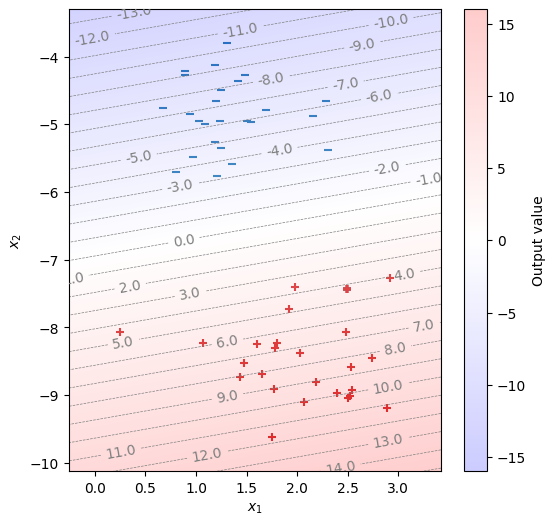

In [172]:
learn_and_plot(model, loader, optimizer)

In [173]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.9811, -3.7178]])),
             ('0.bias', tensor([-25.8188]))])

## ``bias=False``での学習

In [174]:
# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=False),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [175]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=False)
)


In [176]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.1483, -0.2812]]))])

``bias``が消えているいることがわかる。

In [177]:
#パラメータの初期化
nn.init.zeros_(model[0].weight)
model.state_dict()

OrderedDict([('0.weight', tensor([[0., 0.]]))])

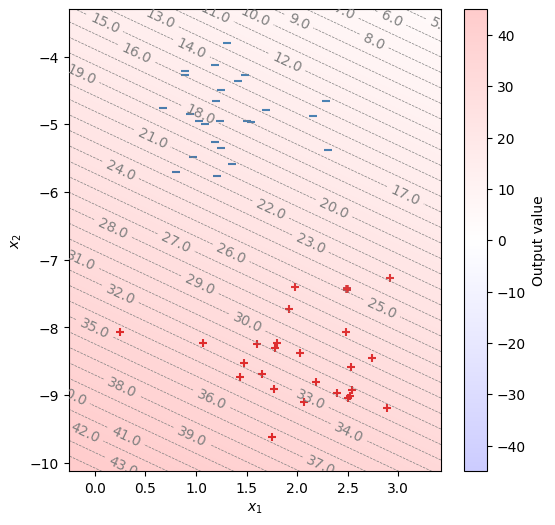

In [178]:
learn_and_plot(model, loader, optimizer)

In [179]:
model.state_dict()

OrderedDict([('0.weight', tensor([[-3.0665, -4.3673]]))])

## バイアスを想定した入力で試す

Xに1.0のベクトルを結合したもので検証してみる。

In [180]:
ones = torch.ones([X.shape[0], 1])
X_bias = torch.cat((X, ones), dim=1)
X_bias.shape

torch.Size([50, 3])

In [181]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X_bias, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=False)

In [182]:
# Single-layer NN: 3 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1, bias=False),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [183]:
print(model)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=False)
)


In [184]:
model.state_dict()

OrderedDict([('0.weight', tensor([[-0.5314,  0.3516, -0.1191]]))])

In [185]:
#パラメータの初期化
nn.init.zeros_(model[0].weight)
model.state_dict()

OrderedDict([('0.weight', tensor([[0., 0., 0.]]))])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1048576x2 and 3x1)

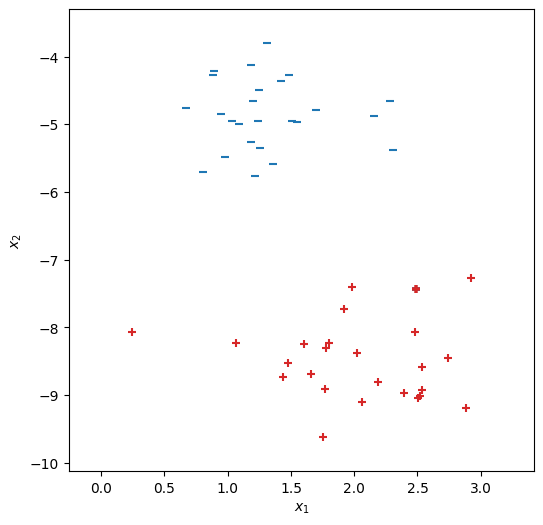

In [186]:
learn_and_plot(model, loader, optimizer)

In [187]:
model.state_dict()

OrderedDict([('0.weight', tensor([[  0.9811,  -3.7178, -25.8188]]))])

``bias=True``での学習と同じ結果になった。

## バイアスを想定した入力で``bias=True``だった場合

In [188]:
# Single-layer NN: 3 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1, bias=True),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [190]:
print(model)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
)


In [191]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.4174, -0.4733, -0.2260]])),
             ('0.bias', tensor([-0.2052]))])

In [192]:
#パラメータの初期化
nn.init.zeros_(model[0].weight)
nn.init.zeros_(model[0].bias)
model.state_dict()

OrderedDict([('0.weight', tensor([[0., 0., 0.]])), ('0.bias', tensor([0.]))])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1048576x2 and 3x1)

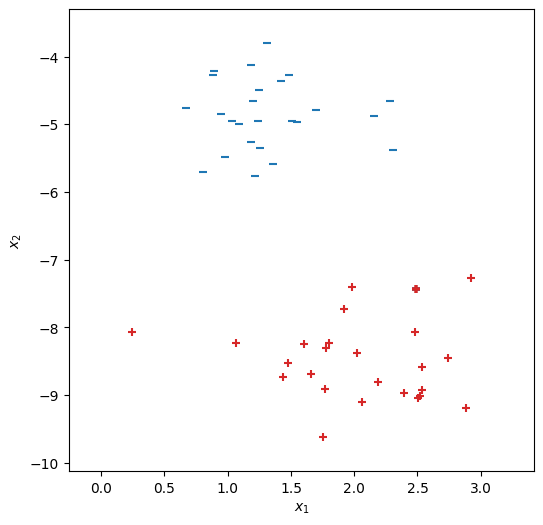

In [193]:
learn_and_plot(model, loader, optimizer)

In [194]:
model.state_dict()

OrderedDict([('0.weight', tensor([[  1.1438,  -4.2081, -14.6844]])),
             ('0.bias', tensor([-14.6844]))])

バイアス部分が2等分になって現れた。

## 結論

nn.Linear()のbiasパラメータはバイアス項を追加するかどうかのパラメータである。
バイアス項が既に含まれている入力に対して単結合層を適用するならFalseにしたほうがよい。